In [1]:
# Import relevant libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2

# import the urllib library
import urllib.request
import os #For checking if a file exists

C:\Users\thuit\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


#### We will be training on the wave data to see how this compares with the models trained on the image data.

# Load in the data:

In [2]:
# Cres0
waves0=np.load("cresWave0.npy")
#And read in the meta data
df0=pd.read_csv("cresSpectMeta0.csv")
print('waves0 has shape: ', np.shape(waves0))

# Cres 1
waves1=np.load("cresWave1.npy")
#And read in the meta data
df1=pd.read_csv("cresSpectMeta1.csv")
print('waves1 has shape: ', np.shape(waves0))

# Concatenate waves
waves = waves0
df = df0
#waves = np.zeros((2000, 200000)) # Pre-allocate for speed
#waves = np.concatenate((waves0, waves1), axis=0)
#print('total concatenated waves array has shape: ', np.shape(waves))

waves0 has shape:  (1000, 200000)
waves1 has shape:  (1000, 200000)


# Plot an example:

Shape of waves array:  (1000, 200000)


Text(0.5, 1.0, 'Event: 550')

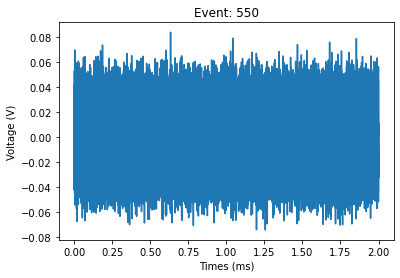

In [3]:
whichEvent = 550

# The times that go with the voltage values
N=len(waves[0]) #200,000 numbers
print('Shape of waves array: ', np.shape(waves))

dt=1e-8 #100MSa/s
dt = dt * 1e3 # Convert seconds to milliseconds

t=np.linspace(0,dt*(N-1),N) #Time array



plt.figure()
plt.plot(t,waves[whichEvent])  # Plot voltage v time
plt.xlabel("Times (ms)")
plt.ylabel("Voltage (V)")
titlestring = 'Event: ' + str(whichEvent)
plt.title(titlestring)

# Prepare the data:

In [4]:
# Set up time and freq arrays
t0_array = df['t0s']*1e3
f0_array = df['f0s']/1e6

# Find max values
t0_array_max = np.max(abs(t0_array))
f0_array_max = np.max(abs(f0_array))

# Normalise time and freq arrays
t0_array_normalised = t0_array/t0_array_max
f0_array_normalised = f0_array/f0_array_max

# Show shapes of arrays
print('t0 array shape: ', np.shape(t0_array_normalised))
print('f0 array shape: ', np.shape(f0_array_normalised))

# Stack data:
labels = np.stack((t0_array_normalised, f0_array_normalised), axis = 1)
print('Stacked labels shape:', np.shape(labels))

t0 array shape:  (1000,)
f0 array shape:  (1000,)
Stacked labels shape: (1000, 2)


Text(0.5, 1.0, 'Event: 550')

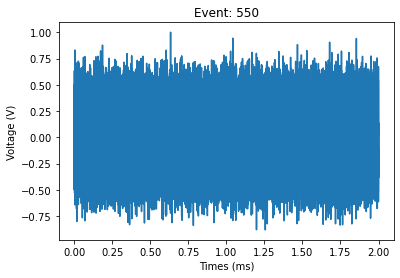

In [5]:
# Pre-allocate array for speed
normed_waves = np.zeros((1000, 200000))

# Normalise data by dividing by the maximum value
for i in range(1000):
    normed_waves[i] = waves[i]/np.max(abs(waves[i]))

# Plot an example
whichEvent = 550
plt.plot(t, normed_waves[whichEvent])  # Plot voltage v time
plt.xlabel("Times (ms)")
plt.ylabel("Voltage (V)")
titlestring = 'Event: ' + str(whichEvent)
plt.title(titlestring)

## Test a non-convolutional neural network

In [6]:
num_samples = 900  # Number of training samples

waves_sample = normed_waves[:num_samples]  # Create training sample, shape (num_samples, 200000)
labels_sample = labels[:num_samples]  # Training labels, shape (num_samples, 2)

val_sample = normed_waves[num_samples:]  # Create validation sample, shape (num_samples, 200000)
val_labels = labels[num_samples:]  # Validaton labels, shape (num_samples, 2)

# Reshape the data to match input shape
waves_sample_reshaped = np.expand_dims(waves_sample, axis=-1)
val_sample_reshaped = np.expand_dims(val_sample, axis=-1)



# Define CNN architecture
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(200000, 1)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),  # Add Dropout layer
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.3),  # Add Dropout layer
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.3),  # Add Dropout layer
    keras.layers.Dense(2, activation='sigmoid')  # OUTPUT layer with 2 neurons (so shape of 2)
])

# Compile the model
model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])

history = model.fit(waves_sample_reshaped, labels_sample, epochs=16, batch_size=32,
                    validation_data=(val_sample_reshaped, val_labels))

Epoch 1/16
29/29 [==============================] - 5s 135ms/step - loss: 0.0608 - accuracy: 0.8444 - val_loss: 0.0542 - val_accuracy: 0.8800
Epoch 2/16
29/29 [==============================] - 4s 126ms/step - loss: 0.0639 - accuracy: 0.8500 - val_loss: 0.0949 - val_accuracy: 0.6000
Epoch 3/16
29/29 [==============================] - 4s 122ms/step - loss: 0.0775 - accuracy: 0.7267 - val_loss: 0.1034 - val_accuracy: 0.5900
Epoch 4/16
29/29 [==============================] - 4s 122ms/step - loss: 0.0637 - accuracy: 0.7044 - val_loss: 0.1120 - val_accuracy: 0.4700
Epoch 5/16
29/29 [==============================] - 4s 126ms/step - loss: 0.0552 - accuracy: 0.7022 - val_loss: 0.1010 - val_accuracy: 0.6300
Epoch 6/16
29/29 [==============================] - 4s 122ms/step - loss: 0.0431 - accuracy: 0.7633 - val_loss: 0.0994 - val_accuracy: 0.5900
Epoch 7/16
29/29 [==============================] - 4s 123ms/step - loss: 0.0311 - accuracy: 0.8267 - val_loss: 0.0920 - val_accuracy: 0.8800
Epoch 

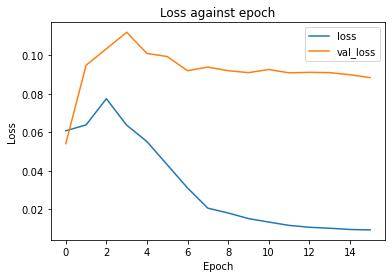

In [7]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('Loss against epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

In [8]:
num_samples = 1000 # Number of prediction samples to test the model

test_waves = normed_waves[:num_samples]
test_waves_reshaped = np.expand_dims(test_waves, axis=-1)

prediction = model.predict(test_waves_reshaped)

32/32 [==============================] - 1s 12ms/step


In [9]:
whichWave = 955

print(prediction[whichWave])
print(labels[whichWave])

[0.5134583 0.5594838]
[0.42028734 0.89943094]


In [10]:
# Calculate squared differences between the coordinates
squared_diff = np.sum(abs(prediction - labels) ** 2, axis=1)

# Take square root of the sum to get distance
distances = np.sqrt(squared_diff)



print('Mean distance for train data: ', np.mean(distances[:900]))
print('Standard deviation for train data: ', np.std(distances[:900]))
print(' ') # Blank line
print('Mean distance for validation data: ', np.mean(distances[900:]))
print('Standard deviation for validation data: ', np.std(distances[900:]))

Mean distance for train data:  0.08461151229746902
Standard deviation for train data:  0.0415428593126429
 
Mean distance for validation data:  0.39962497499598454
Standard deviation for validation data:  0.13115667645921042


# Test a convolutional neural network

In [11]:
num_samples = 900  # Number of training samples

waves_sample = normed_waves[:num_samples]  # Create training sample, shape (num_samples, 200000)
labels_sample = labels[:num_samples]  # Training labels, shape (num_samples, 2)

val_sample = normed_waves[num_samples:]  # Create validation sample, shape (num_samples, 200000)
val_labels = labels[num_samples:]  # Validaton labels, shape (num_samples, 2)

# Reshape the data to match input shape
waves_sample_reshaped = np.expand_dims(waves_sample, axis=-1)
val_sample_reshaped = np.expand_dims(val_sample, axis=-1)



# Define CNN architecture
model = keras.Sequential([
    keras.layers.Conv1D(16, kernel_size=3, activation='relu', input_shape=(200000, 1)),
    keras.layers.Dropout(0.3),  # Add Dropout layerv
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Conv1D(32, kernel_size=3, activation='relu'),
    keras.layers.Dropout(0.3),  # Add Dropout layer
    keras.layers.MaxPooling1D(pool_size=2),
    
    keras.layers.Flatten(),
    keras.layers.Dense(2, activation='linear')  # Output layer with 2 neurons
])

model.summary()

# Compile the model
model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])

history = model.fit(waves_sample_reshaped, labels_sample, epochs=8, batch_size=32,
                    validation_data=(val_sample_reshaped, val_labels))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 199998, 16)        64        
                                                                 
 dropout_3 (Dropout)         (None, 199998, 16)        0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 99999, 16)         0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 99997, 32)         1568      
                                                                 
 dropout_4 (Dropout)         (None, 99997, 32)         0         
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 49998, 32)         0         
 g1D)                                                 

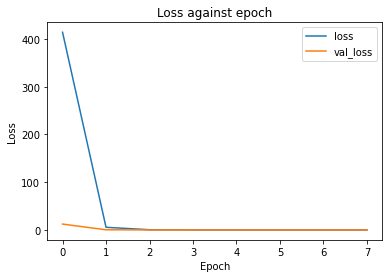

In [12]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('Loss against epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

In [13]:
num_samples = 1000 # Number of prediction samples to test the model

test_waves = normed_waves[:num_samples]
test_waves_reshaped = np.expand_dims(test_waves, axis=-1)

prediction = model.predict(test_waves_reshaped)

32/32 [==============================] - 15s 459ms/step


In [14]:
whichWave = 985 # Values above 900 represent unseen data

print(prediction[whichWave])
print(labels[whichWave])

[0.2501919  0.41191524]
[0.52672527 0.79651623]


In [15]:
# Calculate squared differences between the coordinates
squared_diff = np.sum(abs(prediction - labels) ** 2, axis=1)

# Take square root of the sum to get distance
distances = np.sqrt(squared_diff)



print('Mean distance for train data: ', np.mean(distances[:900]))
print('Standard deviation for train data: ', np.std(distances[:900]))
print(' ') # Blank line
print('Mean distance for validation data: ', np.mean(distances[900:]))
print('Standard deviation for validation data: ', np.std(distances[900:]))

Mean distance for train data:  0.5981383646666419
Standard deviation for train data:  0.21060881791180341
 
Mean distance for validation data:  0.5826737784348104
Standard deviation for validation data:  0.16784228992541758
